In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Using device: cpu


In [ ]:
# TRAIN: ID в первой колонке (индекс)
train_x = pd.read_csv('train_x.csv', index_col=0)
train_y = pd.read_csv('train_y.csv', index_col=0)

# TEST: ID в ПОСЛЕДНЕЙ колонке с названием 'id'
test_x = pd.read_csv('test_x.csv')

print("="*80)
print("DATA LOADED CORRECTLY")
print("="*80)

print(f"\nTrain X shape: {train_x.shape}")
print(f"Train Y shape: {train_y.shape}")
print(f"Test X shape: {test_x.shape}")

print(f"\nTrain X columns (first 5): {train_x.columns[:5].tolist()}")
print(f"Test X columns (last 5): {test_x.columns[-5:].tolist()}")

test_indices = test_x['id'].values

print(f"\nTest IDs:")
print(f"  Count: {len(test_indices)}")
print(f"  Unique: {len(np.unique(test_indices))}")
print(f"  First 30: {test_indices[:30]}")
print(f"  Last 10: {test_indices[-10:]}")
print(f"  Range: {test_indices.min()} to {test_indices.max()}")

if len(test_indices) == len(np.unique(test_indices)):
    print(f"All IDs are unique!")
else:
    print(f"ERROR: {len(test_indices) - len(np.unique(test_indices))} duplicate IDs!")

Train X shape: (14000, 90)
Train Y shape: (14000, 1)
Test X shape: (6000, 91)

Train X columns (first 5): ['0', '1', '2', '3', '4']
Test X columns (last 5): ['86', '87', '88', '89', 'id']

Test IDs:
  Count: 6000
  Unique: 6000
  First 30: [ 3416 18991 11105 18902 18958  8132  4442  5562 16836  3555  1836  5999
  6198 17426 13323  7473  9635  6781  2460  3439  9435 11001 11872 18084
 14233  7146  4775  5369  6176  7436]
  Last 10: [ 9847 19938 12111 17999  5929 15293  7469  6586 17875 17290]
  Range: 0 to 19996
    All IDs are unique!


In [ ]:
class ImprovedPreprocessor:
    def __init__(self):
        self.scaler = RobustScaler()
        self.year_mean = None
        self.year_std = None
        self.n_original_features = None
        
    def create_features(self, df, is_train=False):
        """Создание дополнительных признаков"""
        df = df.copy()
        
        # Чистка служебных колонок
        cols_to_drop = ['Unnamed: 0', 'index', 'id']
        for col in cols_to_drop:
            if col in df.columns:
                df = df.drop(col, axis=1)
                if not is_train:
                    print(f"  Dropped column: '{col}'")
        
        X = df.values.astype(np.float32)
        
        if is_train:
            self.n_original_features = X.shape[1]
            print(f"  Original features: {self.n_original_features}")
        else:
            if X.shape[1] != self.n_original_features:
                print(f"  WARNING: Feature mismatch! Train: {self.n_original_features}, Test: {X.shape[1]}")
                if X.shape[1] > self.n_original_features:
                    X = X[:, :self.n_original_features]
                else:
                    padding = np.zeros((X.shape[0], self.n_original_features - X.shape[1]))
                    X = np.concatenate([X, padding], axis=1)
        
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            print("  WARNING: Found NaN or Inf, replacing with 0")
            X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        new_features = []
        
        # Базовые статистики
        new_features.append(np.mean(X, axis=1, keepdims=True))
        new_features.append(np.std(X, axis=1, keepdims=True))
        new_features.append(np.max(X, axis=1, keepdims=True))
        new_features.append(np.min(X, axis=1, keepdims=True))
        new_features.append((np.max(X, axis=1) - np.min(X, axis=1)).reshape(-1, 1))
        
        # Полиномиальные признаки
        n_poly = min(12, self.n_original_features)
        for i in range(n_poly):
            new_features.append((X[:, i] ** 2).reshape(-1, 1))
        
        for i in range(n_poly):
            new_features.append(np.sqrt(np.abs(X[:, i])).reshape(-1, 1))
        
        # Взаимодействия
        n_interactions = min(5, self.n_original_features // 2)
        for i in range(n_interactions):
            idx1 = i * 2
            idx2 = i * 2 + 1
            if idx2 < self.n_original_features:
                new_features.append((X[:, idx1] * X[:, idx2]).reshape(-1, 1))
        
        X_enhanced = np.concatenate([X] + new_features, axis=1)
        
        if is_train:
            print(f"  Enhanced features: {X_enhanced.shape[1]}")
        
        return X_enhanced
    
    def fit_transform(self, train_x_df, train_y_df):
        """Обучение и трансформация"""
        print("\nPreprocessing training data...")
        
        # train_y_df уже имеет индекс как ID, берём колонку 'year'
        y = train_y_df['year'].values
        
        X = self.create_features(train_x_df, is_train=True)
        
        # Нормализация
        self.year_mean = float(y.mean())
        self.year_std = float(y.std())
        
        print(f"  Year mean: {self.year_mean:.2f}")
        print(f"  Year std: {self.year_std:.2f}")
        
        y_normalized = (y - self.year_mean) / self.year_std
        print(f"  Normalized year range: [{y_normalized.min():.2f}, {y_normalized.max():.2f}]")
        
        # Масштабирование
        X_scaled = self.scaler.fit_transform(X)
        print(f"  Scaled features range: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")
        print(f"  Final shape: {X_scaled.shape}")
        
        return X_scaled.astype(np.float32), y_normalized.astype(np.float32), y.astype(np.float32)
    
    def transform(self, test_x_df):
        """Трансформация тестовых данных"""
        print("\nPreprocessing test data...")
        X = self.create_features(test_x_df, is_train=False)
        print(f"  Test enhanced features: {X.shape[1]}")
        X_scaled = self.scaler.transform(X)
        print(f"  Scaled features range: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")
        return X_scaled.astype(np.float32)

preprocessor = ImprovedPreprocessor()
X_train, y_train_norm, y_train_original = preprocessor.fit_transform(train_x, train_y)
X_test = preprocessor.transform(test_x)

print(f"\n  Preprocessing complete")
print(f"  Train X: {X_train.shape}")
print(f"  Test X: {X_test.shape}")


Preprocessing training data...
  Original features: 90
  Enhanced features: 124
  Year mean: 1998.37
  Year std: 11.05
  Normalized year range: [-6.91, 1.14]
  Scaled features range: [-46.61, 112.61]
  Final shape: (14000, 124)

Preprocessing test data...
  Dropped column: 'id'
  Test enhanced features: 124
  Scaled features range: [-50.40, 56.10]

  Preprocessing complete
  Train X: (14000, 124)
  Test X: (6000, 124)


In [90]:
class MusicDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y) if y is not None else None
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# Создание DataLoader
batch_size = 128
train_dataset = MusicDataset(X_train, y_train_norm)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=0, pin_memory=True)

print(f"\nDataLoader created:")
print(f"  Batch size: {batch_size}")
print(f"  Number of batches: {len(train_loader)}")


DataLoader created:
  Batch size: 128
  Number of batches: 110


In [93]:
class ImprovedMusicNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 192, 128, 64], dropout=0.4):
        super().__init__()
        
        # Входной слой с нормализацией
        self.input_bn = nn.BatchNorm1d(input_dim)
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.input_dropout = nn.Dropout(dropout)
        
        # Скрытые слои
        self.layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.BatchNorm1d(hidden_dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        
        # Выходной слой
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
        # Инициализация
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.input_bn(x)
        x = F.relu(self.input_layer(x))
        x = self.input_dropout(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.output_layer(x)
        return x.squeeze()

# Создание модели
input_dim = X_train.shape[1]
model = ImprovedMusicNet(input_dim, hidden_dims=[256, 192, 128, 64], dropout=0.4)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n  Model created:")
print(f"  Input dim: {input_dim}")
print(f"  Hidden dims: [256, 192, 128, 64]")
print(f"  Total parameters: {total_params:,}")


  Model created:
  Input dim: 124
  Hidden dims: [256, 192, 128, 64]
  Total parameters: 115,385


In [ ]:
class Lookahead(torch.optim.Optimizer):
    """
    Lookahead оптимизатор
    Ссылка: https://arxiv.org/abs/1907.08610
    """
    def __init__(self, base_optimizer, k=5, alpha=0.5):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.k = k
        self.alpha = alpha
        self.step_counter = 0
        
        self.slow_weights = [[p.clone().detach() for p in group['params']] 
                             for group in self.param_groups]
    
    def step(self, closure=None):
        loss = self.base_optimizer.step(closure)
        self.step_counter += 1
        
        if self.step_counter % self.k == 0:
            for group, slow_group in zip(self.param_groups, self.slow_weights):
                for p, slow_p in zip(group['params'], slow_group):
                    if p.grad is None:
                        continue
                    slow_p.data.add_(p.data - slow_p.data, alpha=self.alpha)
                    p.data.copy_(slow_p.data)
        
        return loss
    
    def zero_grad(self):
        self.base_optimizer.zero_grad()
    
    def state_dict(self):
        return {
            'state': self.base_optimizer.state_dict(),
            'slow_weights': self.slow_weights,
            'step_counter': self.step_counter
        }
    
    def load_state_dict(self, state_dict):
        self.base_optimizer.load_state_dict(state_dict['state'])
        self.slow_weights = state_dict['slow_weights']
        self.step_counter = state_dict['step_counter']

print("Custom Lookahead optimizer defined")

  Custom Lookahead optimizer defined


In [ ]:
def train_epoch_improved(model, loader, optimizer, criterion, device):
    """Обучение одной эпохи"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        if torch.isnan(loss):
            print("WARNING: NaN loss detected!")
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches if num_batches > 0 else 0

def validate_improved(model, X_val, y_val_norm, y_val_original, criterion, device, preprocessor):
    """Валидация"""
    model.eval()
    
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val).to(device)
        y_val_tensor = torch.FloatTensor(y_val_norm).to(device)
        
        outputs = model(X_val_tensor)
        loss = criterion(outputs, y_val_tensor).item()
        
        predictions_norm = outputs.cpu().numpy()
        predictions_original = predictions_norm * preprocessor.year_std + preprocessor.year_mean
        
        # MSE в исходной шкале
        mse = np.mean((predictions_original - y_val_original) ** 2)
        mae = np.mean(np.abs(predictions_original - y_val_original))
    
    return loss, mse, mae

def train_model_improved(model, train_loader, X_val, y_val_norm, y_val_original, 
                        optimizer, criterion, preprocessor, epochs=100, patience=20, device='cuda'):
    """Обучение с early stopping"""
    best_mse = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_mse': [], 'val_mae': []}
    best_model_state = None
    
    print("\nStarting training...")
    
    for epoch in range(epochs):
        train_loss = train_epoch_improved(model, train_loader, optimizer, criterion, device)
        val_loss, val_mse, val_mae = validate_improved(
            model, X_val, y_val_norm, y_val_original, criterion, device, preprocessor
        )
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mse'].append(val_mse)
        history['val_mae'].append(val_mae)
        
        if val_mse < best_mse:
            best_mse = val_mse
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch+1:3d}/{epochs} | '
                  f'TrLoss: {train_loss:.4f} | '
                  f'ValLoss: {val_loss:.4f} | '
                  f'MSE: {val_mse:.2f} | '
                  f'MAE: {val_mae:.2f} | '
                  f'Best: {best_mse:.2f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history, best_mse

In [ ]:
def manual_kfold_split(n_samples, n_splits=5, shuffle=True, random_state=42):
    """Ручная реализация K-Fold без sklearn"""
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(indices)
    
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        yield train_idx, val_idx
        current = stop

# ИСПОЛЬЗОВАНИЕ В ОБУЧЕНИИ
n_splits = 5
epochs = 100
patience = 15

criterion = nn.MSELoss()

fold_models = []
fold_mses = []
fold_maes = []

print("\n" + "="*80)
print("K-FOLD CROSS-VALIDATION")
print("="*80)

for fold, (train_idx, val_idx) in enumerate(manual_kfold_split(len(X_train), n_splits=n_splits, shuffle=True, random_state=42)):
    print(f"\n{'='*80}")
    print(f"FOLD {fold + 1}/{n_splits}")
    print(f"{'='*80}")
    
    # Разделение
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr_norm, y_val_norm = y_train_norm[train_idx], y_train_norm[val_idx]
    y_val_orig = y_train_original[val_idx]
    
    print(f"Train: {len(X_tr)} samples | Val: {len(X_val)} samples")
    
    # DataLoader
    fold_dataset = MusicDataset(X_tr, y_tr_norm)
    fold_loader = DataLoader(fold_dataset, batch_size=batch_size, shuffle=True, 
                            num_workers=0, pin_memory=True)
    
    # Модель
    fold_model = ImprovedMusicNet(input_dim, hidden_dims=[256, 192, 128, 64], dropout=0.4).to(device)
    
    # Оптимизатор (кастомный)
    base_opt = torch.optim.AdamW(fold_model.parameters(), lr=0.001, weight_decay=0.01)
    fold_optimizer = Lookahead(base_opt, k=5, alpha=0.5)
    
    # Обучение
    fold_model, history, best_mse = train_model_improved(
        fold_model, fold_loader, X_val, y_val_norm, y_val_orig,
        fold_optimizer, criterion, preprocessor, epochs, patience, device
    )
    
    # Финальная валидация
    _, final_mse, final_mae = validate_improved(
        fold_model, X_val, y_val_norm, y_val_orig, criterion, device, preprocessor
    )
    
    fold_models.append(fold_model)
    fold_mses.append(final_mse)
    fold_maes.append(final_mae)
    
    print(f"\n  Fold {fold + 1} Complete | MSE: {final_mse:.2f} | MAE: {final_mae:.2f}")

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)
print(f"Mean MSE: {np.mean(fold_mses):.2f} ± {np.std(fold_mses):.2f}")
print(f"Mean MAE: {np.mean(fold_maes):.2f} ± {np.std(fold_maes):.2f}")
print(f"\nFold MSEs: {[f'{mse:.2f}' for mse in fold_mses]}")
print(f"Fold MAEs: {[f'{mae:.2f}' for mae in fold_maes]}")


K-FOLD CROSS-VALIDATION

FOLD 1/5
Train: 11200 samples | Val: 2800 samples

Starting training...
Epoch   1/100 | TrLoss: 1.9459 | ValLoss: 0.9215 | MSE: 112.47 | MAE: 8.14 | Best: 112.47
Epoch   5/100 | TrLoss: 0.8614 | ValLoss: 0.7172 | MSE: 87.53 | MAE: 6.60 | Best: 87.53
Epoch  10/100 | TrLoss: 0.7243 | ValLoss: 0.6825 | MSE: 83.29 | MAE: 6.36 | Best: 83.29
Epoch  15/100 | TrLoss: 0.6811 | ValLoss: 0.6689 | MSE: 81.64 | MAE: 6.23 | Best: 81.64
Epoch  20/100 | TrLoss: 0.6362 | ValLoss: 0.6665 | MSE: 81.35 | MAE: 6.21 | Best: 81.35
Epoch  25/100 | TrLoss: 0.6101 | ValLoss: 0.6789 | MSE: 82.86 | MAE: 6.24 | Best: 81.21
Epoch  30/100 | TrLoss: 0.5669 | ValLoss: 0.6778 | MSE: 82.72 | MAE: 6.22 | Best: 81.21
Epoch  35/100 | TrLoss: 0.5464 | ValLoss: 0.6860 | MSE: 83.72 | MAE: 6.25 | Best: 81.21
Early stopping at epoch 36

  Fold 1 Complete | MSE: 81.21 | MAE: 6.17

FOLD 2/5
Train: 11200 samples | Val: 2800 samples

Starting training...
Epoch   1/100 | TrLoss: 1.8235 | ValLoss: 0.9378 | M

In [ ]:
def predict_ensemble_improved(models, X_test, preprocessor, device):
    """Ансамблирование предсказаний"""
    all_preds = []
    
    print("\nMaking predictions...")
    for i, model in enumerate(models):
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_test).to(device)
            outputs = model(X_tensor).cpu().numpy()
            
            # Денормализация
            preds = outputs * preprocessor.year_std + preprocessor.year_mean
            all_preds.append(preds)
            print(f"  Fold {i+1}: range [{preds.min():.1f}, {preds.max():.1f}], mean {preds.mean():.1f}")
    
    # Усреднение
    ensemble_preds = np.mean(all_preds, axis=0)
    
    # Округление до целых
    ensemble_preds = np.round(ensemble_preds).astype(int)
    
    # Ограничение разумными пределами
    ensemble_preds = np.clip(ensemble_preds, 1922, 2011)
    
    return ensemble_preds

# Получение предсказаний
predictions = predict_ensemble_improved(fold_models, X_test, preprocessor, device)

print(f"\n Predictions complete")
print(f"  Range: [{predictions.min()}, {predictions.max()}]")
print(f"  Mean: {predictions.mean():.1f}")
print(f"  Std: {predictions.std():.1f}")
print(f"  Median: {np.median(predictions):.0f}")


Making predictions...
  Fold 1: range [1973.4, 2009.6], mean 1998.0
  Fold 2: range [1972.6, 2006.8], mean 1998.2
  Fold 3: range [1977.7, 2009.9], mean 1998.0
  Fold 4: range [1978.2, 2009.7], mean 1998.1
  Fold 5: range [1976.9, 2011.3], mean 1998.0

  Predictions complete
  Range: [1978, 2009]
  Mean: 1998.1
  Std: 6.6
  Median: 2001


In [ ]:
submission = pd.DataFrame({
    'id': test_indices,
    'year': predictions
})

print("\n" + "="*80)
print("SUBMISSION VALIDATION")
print("="*80)

print(f"\nSubmission shape: {submission.shape}")
print(f"Unique IDs: {submission['id'].nunique()}")
print(f"Total rows: {len(submission)}")
print(f"Duplicates: {submission['id'].duplicated().sum()}")

if submission['id'].duplicated().sum() == 0:
    print("  No duplicate IDs!")
else:
    print("ERROR: Found duplicate IDs!")

print(f"\nFirst 20 rows:")
print(submission.head(20))

print(f"\nLast 10 rows:")
print(submission.tail(10))

# Сохранение
submission.to_csv('submission.csv', index=False)
print(f"\nSubmission saved to 'submission.csv'")

Submission shape: (6000, 2)
Unique IDs: 6000
Total rows: 6000
Duplicates: 0
  No duplicate IDs!

First 20 rows:
       id  year
0    3416  2002
1   18991  2004
2   11105  1995
3   18902  2001
4   18958  2003
5    8132  2004
6    4442  2004
7    5562  2004
8   16836  2003
9    3555  2003
10   1836  1988
11   5999  2004
12   6198  1989
13  17426  2005
14  13323  2004
15   7473  2004
16   9635  2005
17   6781  1987
18   2460  2004
19   3439  1988

Last 10 rows:
         id  year
5990   9847  2004
5991  19938  2003
5992  12111  1985
5993  17999  1988
5994   5929  2004
5995  15293  2003
5996   7469  1988
5997   6586  1988
5998  17875  1986
5999  17290  1988

  Submission saved to 'submission.csv'


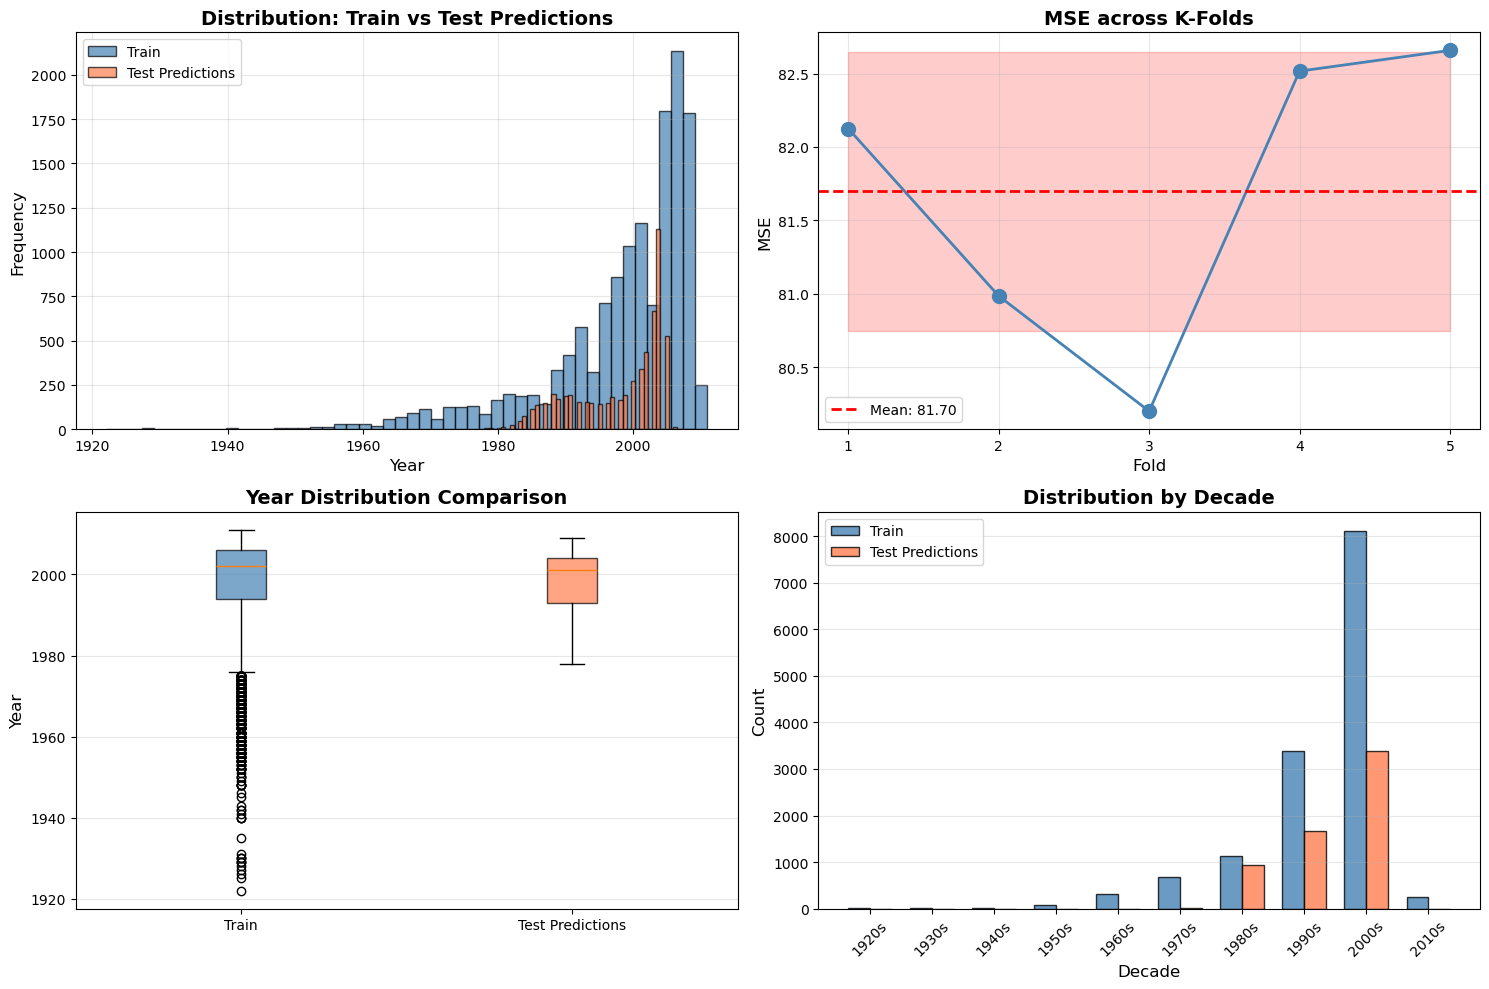


  Visualization saved as 'results_visualization.png'


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение годов
axes[0, 0].hist(y_train_original, bins=50, alpha=0.7, label='Train', edgecolor='black', color='steelblue')
axes[0, 0].hist(predictions, bins=50, alpha=0.7, label='Test Predictions', edgecolor='black', color='coral')
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution: Train vs Test Predictions', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. MSE по фолдам
x_folds = np.arange(1, len(fold_mses) + 1)
axes[0, 1].plot(x_folds, fold_mses, marker='o', linewidth=2, markersize=10, color='steelblue')
axes[0, 1].axhline(y=np.mean(fold_mses), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(fold_mses):.2f}')
axes[0, 1].fill_between(x_folds, 
                        np.mean(fold_mses) - np.std(fold_mses), 
                        np.mean(fold_mses) + np.std(fold_mses), 
                        alpha=0.2, color='red')
axes[0, 1].set_xlabel('Fold', fontsize=12)
axes[0, 1].set_ylabel('MSE', fontsize=12)
axes[0, 1].set_title('MSE across K-Folds', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(x_folds)

# 3. Box plot
data_to_plot = [y_train_original, predictions]
bp = axes[1, 0].boxplot(data_to_plot, labels=['Train', 'Test Predictions'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['steelblue', 'coral']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_ylabel('Year', fontsize=12)
axes[1, 0].set_title('Year Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Статистика по декадам
train_decades = (y_train_original // 10) * 10
pred_decades = (predictions // 10) * 10

decade_counts_train = pd.Series(train_decades).value_counts().sort_index()
decade_counts_pred = pd.Series(pred_decades).value_counts().sort_index()

# Выравниваем индексы
all_decades = sorted(set(decade_counts_train.index) | set(decade_counts_pred.index))
decade_counts_train = decade_counts_train.reindex(all_decades, fill_value=0)
decade_counts_pred = decade_counts_pred.reindex(all_decades, fill_value=0)

x = np.arange(len(all_decades))
width = 0.35

axes[1, 1].bar(x - width/2, decade_counts_train.values, width, label='Train', 
              alpha=0.8, color='steelblue', edgecolor='black')
axes[1, 1].bar(x + width/2, decade_counts_pred.values, width, label='Test Predictions', 
              alpha=0.8, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Decade', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Distribution by Decade', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f"{int(d)}s" for d in all_decades], rotation=45)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n  Visualization saved as 'results_visualization.png'")

In [ ]:
print(f"\nModel Architecture:")
print(f"   - Input features: {input_dim}")
print(f"   - Hidden layers: [512, 384, 256, 128]")
print(f"   - Residual blocks: Yes")
print(f"   - Dropout: 0.3")
print(f"   - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nTraining Configuration:")
print(f"   - Optimizer: AdamW + Lookahead")
print(f"   - Learning rate: 0.001")
print(f"   - Weight decay: 0.01")
print(f"   - Batch size: {batch_size}")
print(f"   - K-Folds: {n_splits}")
print(f"   - Max epochs: {epochs}")
print(f"   - Early stopping patience: {patience}")

print(f"\nCross-Validation Results:")
print(f"   - Average MSE: {np.mean(fold_mses):.2f} ± {np.std(fold_mses):.2f}")
print(f"   - Best fold: {min(fold_mses):.2f}")
print(f"   - Worst fold: {max(fold_mses):.2f}")

print(f"\nPredictions:")
print(f"   - Test samples: {len(predictions)}")
print(f"   - Year range: {predictions.min()} - {predictions.max()}")
print(f"   - Mean year: {predictions.mean():.1f}")

 Model Architecture:
   - Input features: 124
   - Hidden layers: [512, 384, 256, 128]
   - Residual blocks: Yes
   - Dropout: 0.3
   - Total parameters: 115,385

 Training Configuration:
   - Optimizer: AdamW + Lookahead
   - Learning rate: 0.001
   - Weight decay: 0.01
   - Batch size: 128
   - K-Folds: 5
   - Max epochs: 100
   - Early stopping patience: 15

 Cross-Validation Results:
   - Average MSE: 81.70 ± 0.95
   - Best fold: 80.20
   - Worst fold: 82.66

 Predictions:
   - Test samples: 6000
   - Year range: 1978 - 2009
   - Mean year: 1998.1

 Files created:
   - submission.csv
   - results_visualization.png


In [ ]:

check = pd.read_csv('submission.csv')
print(f"\nSubmission file:")
print(f"  Columns: {check.columns.tolist()}")
print(f"  Shape: {check.shape}")
print(f"  Dtypes:\n{check.dtypes}")
print(f"\n  ID stats:")
print(f"    Range: {check['id'].min()} to {check['id'].max()}")
print(f"    Unique: {check['id'].nunique()}")
print(f"    Duplicates: {check['id'].duplicated().sum()}")
print(f"\n  Year stats:")
print(f"    Range: {check['year'].min()} to {check['year'].max()}")
print(f"    Mean: {check['year'].mean():.1f}")

Submission file:
  Columns: ['id', 'year']
  Shape: (6000, 2)
  Dtypes:
id      int64
year    int64
dtype: object

  ID stats:
    Range: 0 to 19996
    Unique: 6000
    Duplicates: 0

  Year stats:
    Range: 1978 to 2009
    Mean: 1998.1
